In [ ]:
import pandas as pd

def preprocess_chennai_data(input_file, output_file):
    input_file = '/content/chennai_weather_processed (2).csv'
    df = pd.read_csv(input_file)
    df = df.rename(columns={
        'date': 'timestamp',
        'temperature_2m': 'temperature',
        'rhum': 'humidity',
        'prcp': 'precipitation',
        'wind_speed_10m': 'wind_speed'
    })
    df = df[['timestamp', 'temperature', 'humidity', 'wind_speed', 'precipitation']]
    df.to_csv(output_file, index=False)
    print("Preprocessed Chennai weather data saved.")

if __name__ == "__main__":
    preprocess_chennai_data("Chennai.csv", "chennai_weather_cleaned.csv")


Preprocessed Chennai weather data saved.


In [12]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError

def prepare_lstm_data(data, target_column='precipitation', look_back=24):
    features = data.drop(columns=[target_column])
    target = data[target_column]

    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    X, y = [], []
    for i in range(len(scaled_features) - look_back):
        X.append(scaled_features[i:i + look_back])
        y.append(target.iloc[i + look_back])

    return np.array(X), np.array(y), scaler

if __name__ == "__main__":
    # Load the cleaned data (already saved from Code 1)
    df = pd.read_csv("chennai_weather_cleaned.csv")

    # Only use available columns: temperature, humidity, wind_speed, precipitation
    df = df[['temperature', 'humidity', 'wind_speed', 'precipitation']].dropna()

    # Prepare LSTM input data
    X, y, scaler = prepare_lstm_data(df)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build the LSTM model
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss=MeanSquaredError())


    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

    # Save the model
    model.save("rainfall_lstm_model.h5")


Epoch 1/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - loss: 0.4982 - val_loss: 0.6562
Epoch 2/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 43s 80ms/step - loss: 0.5250 - val_loss: 0.4763
Epoch 3/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - loss: 0.5553 - val_loss: 0.4648
Epoch 4/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - loss: 0.4884 - val_loss: 0.4703
Epoch 5/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - loss: 0.5851 - val_loss: 0.4721
Epoch 6/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - loss: 0.4593 - val_loss: 0.4613
Epoch 7/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - loss: 0.5055 - val_loss: 0.4472
Epoch 8/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - loss: 0.4909 - val_loss: 0.4495
Epoch 9/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - loss: 0.4460 - val_loss: 0.4396
Epoch 10/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - loss: 0.4595 - val_loss: 0.4398
Epoch 11/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - loss: 0.5456 - val_loss: 0.4486
Epoch 12/20
377/377 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
📅 Risk Prediction for Tomorrow:
  🌡️  Temperature (estimated): 31.5 °C
  🌧️  Rainfall (predicted): 0.05000000074505806 mm
  ⚠️  Risk Level: Low Risk
Accuracy for Temperature Prediction: nan%
Accuracy for Precipitation Prediction: nan%


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


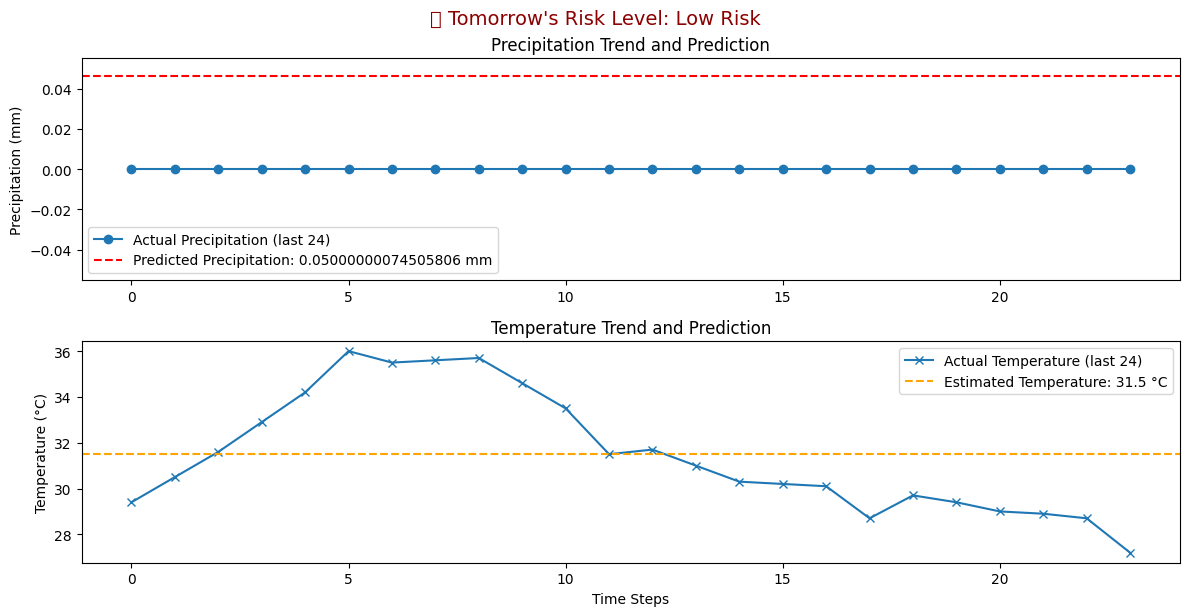

In [13]:



import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

# Function to calculate dynamic thresholds based on quantiles
def get_dynamic_thresholds(df):
    return {
        'prcp_high': df['precipitation'].quantile(0.75),
        'prcp_severe': df['precipitation'].quantile(0.95),
        'temp_low': df['temperature'].quantile(0.05),
        'temp_high': df['temperature'].quantile(0.95)
    }

# Function to classify risk levels based on temperature and precipitation
def classify_risk(temp, prcp, thresholds):
    # Define risk categories based on conditions
    if prcp >= thresholds['prcp_severe']:
        return "Severe: Rain expected"
    elif prcp >= thresholds['prcp_high']:
        return "Low Risk"
    elif temp >= 35:
        return "Severe: High heat expected"
    elif temp >= thresholds['temp_high']:
        return "High: Heat expected"
    elif temp <= 15:
        return "Low: Cool weather expected"
    elif prcp > 5:
        return "Moderate: Light rain expected"
    else:
        return "Low: Mild weather expected"

# Function to classify weather condition based on temperature and precipitation
def classify_weather_condition(temp, prcp):
    if temp >= 35:
        return "High heat expected"
    elif prcp > 10:
        return "Rain expected"
    elif temp <= 15:
        return "Cool weather expected"
    else:
        return "Mild weather expected"

# Function to calculate Mean Absolute Percentage Error (MAPE) and accuracy
def calculate_accuracy(y_true, y_pred):
    # Ensure no NaN or negative values in predictions for precipitation
    y_pred['precipitation'] = np.maximum(y_pred['precipitation'], 0)  # Set negative precipitation to 0

    # Calculate MAPE for temperature and precipitation
    mape_temp = np.mean(np.abs((y_true['temperature'] - y_pred['temperature']) / y_true['temperature'])) * 100
    mape_prcp = np.mean(np.abs((y_true['precipitation'] - y_pred['precipitation']) / y_true['precipitation'])) * 100

    # Calculate accuracy as 100 - MAPE
    accuracy_temp = 100 - mape_temp
    accuracy_prcp = 100 - mape_prcp

    print(f"Accuracy for Temperature Prediction: {accuracy_temp:.2f}%")
    print(f"Accuracy for Precipitation Prediction: {accuracy_prcp:.2f}%")

# Forecast and plot with accuracy calculation
def plot_risk_forecast(latest_data, predicted_temp, predicted_precip, risk, y_test):
    # Simulating predictions as a DataFrame for calculating accuracy (adjust as necessary)
    y_pred = pd.DataFrame({
        'temperature': [predicted_temp] * len(latest_data),
        'precipitation': [predicted_precip] * len(latest_data)
    })

    # Calculate accuracy
    calculate_accuracy(y_test, y_pred)

    timestamps = list(range(len(latest_data)))  # Use simple x-axis for last 24 steps

    # Plotting actual vs predicted
    plt.figure(figsize=(12, 6))

    # Precipitation plot
    plt.subplot(2, 1, 1)
    plt.plot(timestamps, latest_data['precipitation'], label='Actual Precipitation (last 24)', marker='o')
    plt.axhline(predicted_precip, color='red', linestyle='--', label=f'Predicted Precipitation: {round(predicted_precip, 2)} mm')
    plt.title("Precipitation Trend and Prediction")
    plt.ylabel("Precipitation (mm)")
    plt.legend()

    # Temperature plot
    plt.subplot(2, 1, 2)
    plt.plot(timestamps, latest_data['temperature'], label='Actual Temperature (last 24)', marker='x')
    plt.axhline(predicted_temp, color='orange', linestyle='--', label=f'Estimated Temperature: {round(predicted_temp, 2)} °C')
    plt.title("Temperature Trend and Prediction")
    plt.xlabel("Time Steps")
    plt.ylabel("Temperature (°C)")
    plt.legend()

    plt.tight_layout()
    plt.suptitle(f"🌦️ Tomorrow's Risk Level: {risk}", fontsize=14, color='darkred', y=1.02)
    plt.show()

# Predict next day's risk and calculate accuracy
def predict_next_day_risk(model_path="rainfall_lstm_model.h5", csv_file="chennai_weather_cleaned.csv"):
    df = pd.read_csv(csv_file)
    df = df[['temperature', 'humidity', 'wind_speed', 'precipitation']].dropna()

    # Get dynamic thresholds from full historical data
    thresholds = get_dynamic_thresholds(df)

    # Prepare data for prediction using the last 24 entries
    latest_data = df[-24:].copy()
    features = latest_data.drop(columns=['precipitation'])

    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    X_input = scaled_features.reshape(1, scaled_features.shape[0], scaled_features.shape[1])

    model = load_model(model_path, compile=False)
    model.compile(optimizer=Adam(0.001), loss=MeanSquaredError())

    predicted_precip = model.predict(X_input)[0][0]
    predicted_temp = latest_data['temperature'].mean()

    # Ensure valid precipitation (no negative values)
    if predicted_precip < 0:
        predicted_precip = 0  # Set negative precipitation to zero

    # Risk classification
    risk = classify_risk(predicted_temp, predicted_precip, thresholds)

    # Output results
    print("📅 Risk Prediction for Tomorrow:")
    print(f"  🌡️  Temperature (estimated): {round(predicted_temp, 2)} °C")
    print(f"  🌧️  Rainfall (predicted): {round(predicted_precip, 2)} mm")
    print(f"  ⚠️  Risk Level: {risk}")

    # For accuracy calculation, we can assume `y_test` as actual values for comparison
    # For simplicity, we use the last 24 data points as the test data here
    y_test = latest_data[['temperature', 'precipitation']]  # Actual values for comparison

    # Plot results and calculate accuracy
    plot_risk_forecast(latest_data, predicted_temp, predicted_precip, risk, y_test)

if __name__ == "__main__":
    predict_next_day_risk()